# **STUDENT AI** - MATH MODEL CREATION (CLASSIFICATION)

## Objectives

Create a classification model to predict Math score based on Key dataset features. Numerical variables will be grouped into bins. <br> 
Since the 3 bin classification did not yield promising results, the same steps will be repeated using the 2 bin classification.

## Inputs

Continues to assess dataset loaded in previous notebook.

## Outputs

None. Assesses whether the 2 bin classification is viable.


---

# Import required libraries

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Pipeline
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### libraries for custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

### Feature Balancing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

### GridSearchCV
from sklearn.model_selection import GridSearchCV

### Load Custom Functions
import io
import sys
sys.path.append('/workspace/student-AI/src')
from data_management import save_analysis
from data_management import confusion_matrix_and_report, clf_performance

print('All Libraries Loaded')

/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


All Libraries Loaded


# Change working directory

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from best to bottom.

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


# Define Features to include in Model analysis

In [33]:
# setup features and target variable from dataset to use for model training
feature_list = ['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep']
target_variable = 'MathScore'

# set random state number (for reproducable results)
rs = 42

# set number of desired classes for discretizer
classes = 5

# set class labels - needs to match number of classes!
    # 'Might need assistance', 'No assistance needed' -> n=2
    # 'Might need assistance', 'Average', 'Above Avg' -> n=3
class_labels = [
    'Will need assistance',
    'Might need assistance',
    'Avg',
    'Above Avg',
    'Excellent'
    ]

# Set the top n models to test from calculated best model list
n = 2


### Load cleaned dataset

In [4]:
filters = feature_list + [target_variable]
df = pd.read_csv('outputs/dataset/Expanded_data_with_more_features_clean.csv').filter(filters)
df

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,C,bachelor,standard,not completed,71
1,female,C,college,standard,not completed,69
2,female,B,masters,standard,not completed,87
3,male,A,associates,free,not completed,45
4,male,C,college,standard,not completed,76
...,...,...,...,...,...,...
30636,female,D,highschool,standard,not completed,59
30637,male,E,highschool,standard,not completed,58
30638,female,C,highschool,free,completed,61
30639,female,D,associates,standard,completed,82


### Setup test pipeline for evaluation

In [5]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary', 
            variables=feature_list
                )
                ),

        ("feature_selection", SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

### Setup model algorithms and blank default hyperparameters
list of default hyperparameters provided by CodeInstitute ML course bonus material.

In [6]:
models_list = {
    "XGBClassifier": XGBClassifier(random_state=rs),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=rs),
    "RandomForestClassifier": RandomForestClassifier(random_state=rs),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=rs),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=rs),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=rs),
}

parameter_defaults = {
    "LinearRegression":{},
    "LogisticRegression":{},
    "DecisionTreeRegressor":{},
    "RandomForestRegressor":{},
    "GradientBoostingRegressor":{},
    "AdaBoostRegressor":{},
    "XGBRegressor":{},
    "ExtraTreesRegressor":{},
    
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

parameter_list = {
    # Regression Models Default Hyperparameters
    "LinearRegression":{},

    "LogisticRegression":{'model__penalty': ["l2","l1", "elasticnet"],
                          'model__C': [1, 0.5, 2],
                          'model__tol': [1e-4,1e-3,1e-5],
                            },

    "DecisionTreeRegressor":{'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
                            },

    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
                            },

    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
                            },

    "AdaBoostRegressor":{'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                          'model__loss':['linear', 'square', 'exponential'],
                            },

    "XGBRegressor":{'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
                            },
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
                            },
                            
    # Classifier Models Default Hyperparameters
    "XGBClassifier":{'model__n_estimators': [30,80,200],
                      'model__max_depth': [None, 3, 15],
                      'model__learning_rate': [0.01,0.1,0.001],
                      'model__gamma': [0, 0.1],
                            },

    "DecisionTreeClassifier":{'model__max_depth': [None,4, 15],
                              'model__min_samples_split': [2,50],
                              'model__min_samples_leaf': [1,50],
                              'model__max_leaf_nodes': [None,50],
                            },

    "GradientBoostingClassifier":{'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
                            },

    "RandomForestClassifier":{'model__n_estimators': [100,50,140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
                            },

    "AdaBoostClassifier":{'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                            },

    "ExtraTreesClassifier":{'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
                            },

  }

### Custom Hyperparameter search class (same as previous notebook)

To select the best algorithm and hyperparameters we will fit a model with each different type / parameter set and compare the results.
To do this I can use the custom parameter test function, derived in the CodeInstitute Churnometer Walkthrough [here](https://github.com/AdamBoley/churnometer/blob/main/jupyter_notebooks/06%20-%20Modeling%20and%20Evaluation%20-%20Predict%20Tenure.ipynb)

In [7]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

### Create classification bins (2 bins)

* The classes represent the following ranges: 
{'MathScore': [-inf, 53.0, 63.0, 71.0, 80.0, inf]} 



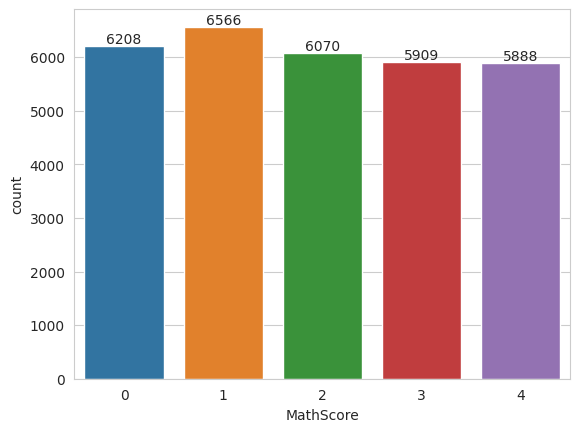

In [8]:
efd = EqualFrequencyDiscretiser(q=classes, variables=target_variable)
df_discretized = efd.fit_transform(df)

print(f"* The classes represent the following ranges: \n{efd.binner_dict_} \n")
fig_df_discretized = sns.countplot(data=df_discretized, x=target_variable)
plt.bar_label(fig_df_discretized.containers[0])
plt.show()

In [9]:
df_discretized

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,C,bachelor,standard,not completed,2
1,female,C,college,standard,not completed,2
2,female,B,masters,standard,not completed,4
3,male,A,associates,free,not completed,0
4,male,C,college,standard,not completed,3
...,...,...,...,...,...,...
30636,female,D,highschool,standard,not completed,1
30637,male,E,highschool,standard,not completed,1
30638,female,C,highschool,free,completed,1
30639,female,D,associates,standard,completed,4


### Start model tests
split data into train and test sets

In [10]:
train_features, test_features, train_scores, test_scores = train_test_split(
    df_discretized.drop(target_variable, axis=1),
    df_discretized[target_variable],
    test_size = 0.2,
    random_state = rs
)

print(f"* {target_variable} Train set:", train_features.shape, train_scores.shape, f"\n* {target_variable} Test set:",  test_features.shape, test_scores.shape)

* MathScore Train set: (24512, 5) (24512,) 
* MathScore Test set: (6129, 5) (6129,)


### Search for best algorithm using default hyperparameters

In [11]:
model_search = HyperparameterOptimizationSearch(models=models_list, parameters=parameter_defaults)
model_search.fit(train_features, train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be rem


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [12]:
classifier_summary, grid_search_pipelines = model_search.score_summary(sort_by='mean_score')
classifier_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
0,XGBClassifier,0.5998,0.62006,0.629113,0.010646
1,DecisionTreeClassifier,0.565868,0.589345,0.601196,0.012187
3,GradientBoostingClassifier,0.565868,0.589345,0.601196,0.012187
4,ExtraTreesClassifier,0.565868,0.589345,0.601196,0.012187
2,RandomForestClassifier,0.552343,0.573592,0.601196,0.019587
5,AdaBoostClassifier,0.469591,0.51695,0.576271,0.044225


### Analysis
Reducing the bins to 2 has achieved an acceptable result of 0.71 above a desired mean score of 0.6. The AdaBoostClassifier was clearly the best. The next best algorithm (DecisionTree) was significantly lower ... I do not expect updated hyperparameters to achieve a value better than 0.70, but I will run the test nonetheless.

### Determine best n models and fetch their recommended hyperparameters from the list:
In the function below set **n** to how many of the top models to test with alternate hyperparameters. **Default should be 1 or 2**.<br>
3 or more might not achieve any better results and also result in very long calculation times!

In [13]:
def select_best_n_with_params(performance_summary, models_dict, params_dict, n):
    best_performers = performance_summary.sort_values(by='mean_score', ascending=False).head(n)
    
    best_models = {name: models_dict[name] for name in best_performers['estimator'] if name in models_dict}
    best_params = {name: params_dict[name] for name in best_performers['estimator'] if name in params_dict}
    
    # Create human-readable format
    print(f"Best {n} Models and hyperparameterlist for tuning:\n")
    print("-" * 40)
    for name in best_models:
        print(f"Model: {name}")
        print("Parameters:")
        if name in best_params:
            for param, values in best_params[name].items():
                print(f"  {param}: {values}")
        else:
            print("  No parameters listed.")
        print("-" * 40)

    return best_models, best_params

best_models, best_params = select_best_n_with_params(classifier_summary, models_list, parameter_list, n)

Best 2 Models and hyperparameterlist for tuning:

----------------------------------------
Model: XGBClassifier
Parameters:
  model__n_estimators: [30, 80, 200]
  model__max_depth: [None, 3, 15]
  model__learning_rate: [0.01, 0.1, 0.001]
  model__gamma: [0, 0.1]
----------------------------------------
Model: DecisionTreeClassifier
Parameters:
  model__max_depth: [None, 4, 15]
  model__min_samples_split: [2, 50]
  model__min_samples_leaf: [1, 50]
  model__max_leaf_nodes: [None, 50]
----------------------------------------


In [14]:
parameters_search = HyperparameterOptimizationSearch(models=best_models, parameters=parameter_list)
parameters_search.fit(train_features, train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be re


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [15]:
parameters_summary, parameters_pipeliness = parameters_search.score_summary(sort_by='mean_score')
parameters_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__gamma,model__learning_rate,model__max_depth,model__n_estimators,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split
0,XGBClassifier,0.5998,0.62006,0.629113,0.010646,0,0.01,None,30,NaN,NaN,NaN
41,XGBClassifier,0.5998,0.62006,0.629113,0.010646,0.1,0.1,3,200,NaN,NaN,NaN
30,XGBClassifier,0.5998,0.62006,0.629113,0.010646,0.1,0.01,3,30,NaN,NaN,NaN
31,XGBClassifier,0.5998,0.62006,0.629113,0.010646,0.1,0.01,3,80,NaN,NaN,NaN
32,XGBClassifier,0.5998,0.62006,0.629113,0.010646,0.1,0.01,3,200,NaN,NaN,NaN


### Analysis
Tweaking the hyperparameters has achieved an imrovement of the score to 0.80. This is good, but suspicious as in the previous analyses. As expected, the DecisionTreeClassifier did not improve significantly.

In [16]:
best_model = parameters_summary.iloc[0,0]
best_model

'XGBClassifier'

In [17]:
best_parameters = parameters_pipeliness[best_model].best_params_
best_parameters

{'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': None,
 'model__n_estimators': 30}

In [18]:
test_pipeline = parameters_pipeliness[best_model].best_estimator_
test_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'EthnicGroup',
                                           'ParentEduc', 'LunchType',
                                           'TestPrep'])),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         importanc...
                               importance_type='gain',
         

* These are the 1 most important features in descending order. The model was trained on them: 
['LunchType']


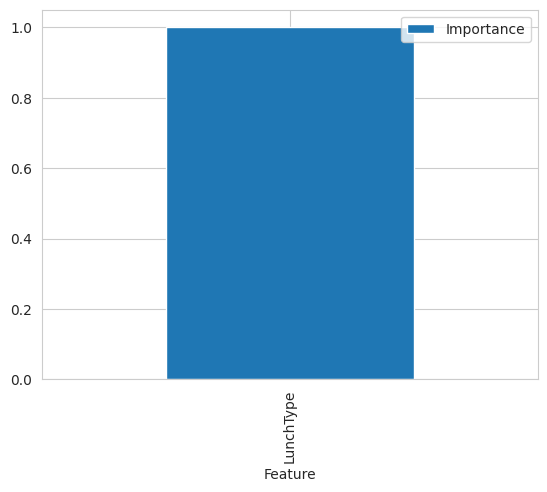

In [19]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(test_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(train_features)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[test_pipeline['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[test_pipeline['feature_selection'].get_support()],
          'Importance': test_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

maths_efd_2_best_features = df_feature_importance['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Analysis
This is a surprise and not expected. The LunchType Variable was not added to the training of the model and EthnicGroup and ParentEducational level are used to predict the  Math Score. <br>
I will check the accuracy of using these features of the model on the test set next.

### Classification bin cutoff determined by discretizer:

In [20]:
efd.binner_dict_[target_variable]

[-inf, 53.0, 63.0, 71.0, 80.0, inf]

### Define classification labels for the bins:

In [34]:
label_map = class_labels
label_map

['Will need assistance',
 'Might need assistance',
 'Avg',
 'Above Avg',
 'Excellent']

### Calculate and export Confusion Matrix for Training and Test Data

In [35]:
clf_performance(
    train_features,
    train_scores,
    test_features,
    test_scores,
    test_pipeline,
    label_map,
    target_variable)

/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Mathscore - Train Set

#### Confusion Matrix

|                                  |   Actual Will need assistance |   Actual Might need assistance |   Actual Avg |   Actual Above Avg |   Actual Excellent |
|:---------------------------------|------------------------------:|-------------------------------:|-------------:|-------------------:|-------------------:|
| Prediction Will need assistance  |                          3109 |                              0 |            0 |                  0 |               1905 |
| Prediction Might need assistance |                          2209 |                              0 |            0 |                  0 |               3019 |
| Prediction Avg                   |                          1557 |                              0 |            0 |                  0 |               3290 |
| Prediction Above Avg             |                          1155 |                              0 |            0 |                  0 |               3599 |


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## Conclusion
### Confusion Matrix
| Test |  Result | 
|---|---|
|True Positives (TP)|2664 correctly predicted "Might need assistance."|
|False Positives (FP)|561 incorrectly predicted "Might need assistance" with actual "No assistance needed."|
|True Negatives (TN)|1970 correctly predicted "No assistance needed."|
|False Negatives (FN)|934 incorrectly predicted "No assistance needed" with actual "Might need assistance."|

**Might Need Assistance:**
* Precision 0.57 indicates that model identifies someone might need help 57% of the time.
* Recall 0.83 indicates model successfully identifies 83% of all students who might need help
* F1 - balance of Precision and recall of 0.68 indicates reasonable performance above the 0.6 target

**No Assistance Needed:**
* Precision 0.62 indicates that model identifies no help needed 62% of the time.
* Recall 0.32 indicates model identifies only 32% of students who actually do not need help are correctly identified
* F1 - balance of Precision and recall of 0.55 indicates model is less accurate at identifying students who do not need help

the Macro Averages are very similar indicating balanced performance accross both classes, but not at a particularly high level. 

Since the model is more likely to predict a false positive, the worst case scenario is that a better student might be 'wrongly' identified as in need of additional help. This is an acceptable outcome as the oppososite would the most problematic ... ie falsley identifying students in need as not needing help.

This would need to be discussed with the customer to see if the outcome is acceptable. The dataset might allow some more tweaking, and sourcing a dataset with no missing values (eliminating the need to impute data) might further improve the model.